# Ensemble Learning and Random Forests
Wisdom of the crowd FTW!

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Voting Classifiers
Using `make_moon` generated dataset: 2 features, 1 binary target variable

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

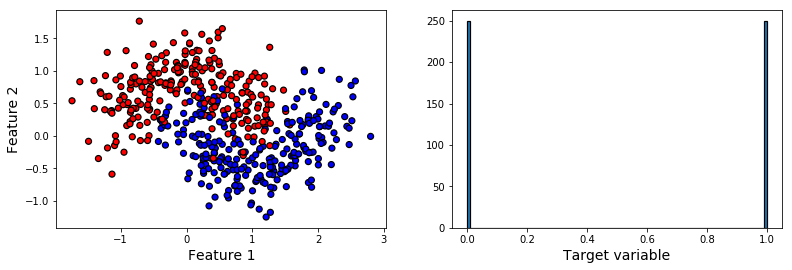

In [85]:
plt.figure(figsize=(13,4))
plt.subplot(121)

cm_bright = ListedColormap(['#FF0000', '#0000FF'])
h = plt.scatter(X[:,0], X[:,1], c = y, cmap=cm_bright, edgecolors='k')
plt.xlabel('Feature 1', fontsize=14)
plt.ylabel('Feature 2', fontsize=14)

plt.subplot(122)

plt.hist(y, edgecolor='k', bins=100)
plt.xlabel('Target variable', fontsize=14)
plt.show()


### Hard voting

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(estimators = [('logreg',log_clf), ('ranfor',rnd_clf), ('svm',svm_clf)],
                              voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('ranfor',...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    print("%s Accuracy: %.3f AUC %.3f" % (clf.__class__.__name__, accuracy_score(y_test, y_pred), auc(fpr, tpr)))

LogisticRegression Accuracy: 0.864 AUC 0.865
RandomForestClassifier Accuracy: 0.864 AUC 0.866
SVC Accuracy: 0.888 AUC 0.890
VotingClassifier Accuracy: 0.888 AUC 0.890


C:\Users\elder\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Soft voting
Uses the class probability (rather than the predicted class) when merging the models. It performs better (0.896 -> 0.921)

In [45]:
svm_clf_prob = SVC(probability=True)

voting_clf = VotingClassifier(estimators = [('logreg',log_clf), ('ranfor',rnd_clf), ('svm',svm_clf_prob)],
                              voting='soft')

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    print("%s Accuracy: %.3f AUC %.3f" % (clf.__class__.__name__, accuracy_score(y_test, y_pred), auc(fpr, tpr)))

LogisticRegression Accuracy: 0.864 AUC 0.865
RandomForestClassifier Accuracy: 0.888 AUC 0.889
SVC Accuracy: 0.888 AUC 0.890
VotingClassifier Accuracy: 0.920 AUC 0.921


C:\Users\elder\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Bagging ensembles
*Bagging* = Bootstrap aggregating. Means sample is performed with replacement. Otherwise it would be called *pasting*.

Training models on random subsets of the training set then using the mode (hard vote) for classification tasks or the average for regression tasks.

In [51]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred_bagging = bag_clf.predict(X_test)

In [52]:
## A single decision tree for comparison
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print("Single decision tree: ", accuracy_score(y_test, y_pred_tree))
print("Bagging: ", accuracy_score(y_test, y_pred_bagging))

Single decision tree:  0.856
Bagging:  0.92


In [73]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff'])
    plt.contourf(x1, x2, y_pred, alpha=0.2, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

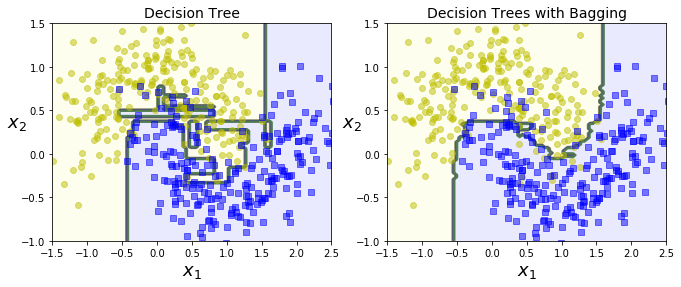

In [74]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

### Out-of-Bag Evaluation

In [89]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            bootstrap=True, n_jobs=-1, oob_score = True)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [90]:
print("OOB score: ", bag_clf.oob_score_)
y_pred = bag_clf.predict(X_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

OOB score:  0.8906666666666667
Accuracy score:  0.896
